# Word2Vec


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

from word2vec import (
   Vocabulary, 
    Word2VecDataset, 
    SkipGram, 
    CBOW,
    NegativeSampler,
    tokenize_corpus,
    find_similar_words,
    word_analogy)

torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Training Data
Lyrics of 
- Linkin Park
- Pink Floyd
- Nirvana
- The Beatles
- Metalica
- The Doors

In [3]:
try:
    with open('music_corpus.txt', 'r', encoding='utf-8') as f:
        corpus = f.read()
    print(f"First 300 chars preview:\n{'-'*50}\n{corpus[:300]}...\n{'-'*50}")
except FileNotFoundError:
    print("music_corpus.txt' not found")
    
sentences = tokenize_corpus(corpus)
print(f"Number of sentences: {len(sentences)}")
print(f"Sample sentence: {sentences[0]}")

First 300 chars preview:
--------------------------------------------------
It starts with one

One thing, I don't know why
It doesn't even matter how hard you try
Keep that in mind, I designed this rhyme
To explain in due time, all I know
Time is a valuable thing
Watch it fly by as the pendulum swings
Watch it count down to the end of the day
The clock ticks life away, 
it...
--------------------------------------------------
Number of sentences: 61
Sample sentence: ['it', 'starts', 'with', 'one', 'one', 'thing', 'i', 'dont', 'know', 'why', 'it', 'doesnt', 'even', 'matter', 'how', 'hard', 'you', 'try', 'keep', 'that', 'in', 'mind', 'i', 'designed', 'this', 'rhyme', 'to', 'explain', 'in', 'due', 'time', 'all', 'i', 'know', 'time', 'is', 'a', 'valuable', 'thing', 'watch', 'it', 'fly', 'by', 'as', 'the', 'pendulum', 'swings', 'watch', 'it', 'count', 'down', 'to', 'the', 'end', 'of', 'the', 'day', 'the', 'clock', 'ticks', 'life', 'away', 'its', 'so', 'unreal', 'didnt', 'look', 'out', 'bel

## Build Vocabulary

In [4]:
vocab = Vocabulary(min_count=2)  
vocab.build_vocab(sentences)
# Only unique ones (SIZE)
print(f"\nVocabulary size: {vocab.vocab_size}")
print(f"\nMost common words:")
# all occurences
for word, count in vocab.word_counts.most_common(10):
    print(f"  {word}: {count}")

Size is 2072 words (min count=2)

Vocabulary size: 2072

Most common words:
  the: 1788
  i: 1496
  you: 1189
  to: 1006
  and: 792
  me: 755
  a: 712
  in: 627
  of: 535
  it: 499


## Configuration

In [55]:
EMBEDDING_DIM = 100      
WINDOW_SIZE = 3          
NUM_NEGATIVE = 5         
BATCH_SIZE = 128         
LEARNING_RATE = 0.005    
NUM_EPOCHS = 60         
MODE = 'skipgram'        

## Dataset

In [60]:
dataset = Word2VecDataset(sentences, vocab, window_size=WINDOW_SIZE, mode=MODE)
print("Training pairs:", len(dataset))

for i in range(5):
    pair = dataset[i]

    if MODE == "skipgram":
        center, context = pair
        print(vocab.get_word(center), "->", vocab.get_word(context))

    else:  
        context_words, center = pair
        context = [vocab.get_word(w) for w in context_words]
        print(context, "->", vocab.get_word(center))


Training pairs: 250320
it -> starts
it -> with
it -> one
starts -> it
starts -> with


## Model Intialization 

In [61]:
if MODE == 'skipgram':
    model = SkipGram(vocab.vocab_size, EMBEDDING_DIM).to(device)
else:
    model = CBOW(vocab.vocab_size, EMBEDDING_DIM).to(device)

neg_sampler = NegativeSampler(vocab)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print(f"Model initialized: {model.__class__.__name__}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters())}")

Model initialized: SkipGram
Total parameters: 414400


## Training

In [66]:
def collate_fn_skipgram(batch):
    centers  = torch.LongTensor([c for c, _ in batch])
    contexts = torch.LongTensor([ctx for _, ctx in batch])

    neg = torch.LongTensor([neg_sampler.sample(NUM_NEGATIVE) for _ in batch])
    return centers, contexts, neg


In [67]:
def collate_fn_cbow(batch):
    max_len = max(len(ctx) for ctx, _ in batch)
    contexts = [
        ctx + [0] * (max_len - len(ctx))
        for ctx, _ in batch
    ]
    contexts = torch.LongTensor(contexts)
    centers = torch.LongTensor([c for _, c in batch])

    neg = torch.LongTensor([neg_sampler.sample(NUM_NEGATIVE) for _ in batch])

    return contexts, centers, neg


In [68]:
collate_fn = collate_fn_skipgram if MODE == "skipgram" else collate_fn_cbow

dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn
)


In [69]:
losses = []
model.train()

print("\n Training Started \n")

for epoch in range(NUM_EPOCHS):
    epoch_loss = 0

    for batch in dataloader:
        if MODE == "skipgram":
            center, context, neg = batch
            loss = model(center.to(device), context.to(device), neg.to(device))
        else:
            context, center, neg = batch
            loss = model(context.to(device), center.to(device), neg.to(device))

        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(dataloader)
    losses.append(avg_loss)

    if (epoch + 1) % 3 == 0:
        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {avg_loss:.4f}")

print("\nTraining completed")



Starting training...

Epoch [3/60], Loss: 1.8778
Epoch [6/60], Loss: 1.7576
Epoch [9/60], Loss: 1.7350
Epoch [12/60], Loss: 1.7232
Epoch [15/60], Loss: 1.7184
Epoch [18/60], Loss: 1.7174
Epoch [21/60], Loss: 1.7134
Epoch [24/60], Loss: 1.7135
Epoch [27/60], Loss: 1.7162
Epoch [30/60], Loss: 1.7137
Epoch [33/60], Loss: 1.7129
Epoch [36/60], Loss: 1.7131
Epoch [39/60], Loss: 1.7129
Epoch [42/60], Loss: 1.7098
Epoch [45/60], Loss: 1.7093
Epoch [48/60], Loss: 1.7121
Epoch [51/60], Loss: 1.7120
Epoch [54/60], Loss: 1.7136
Epoch [57/60], Loss: 1.7107
Epoch [60/60], Loss: 1.7065

Training completed!


## Visualize Loss

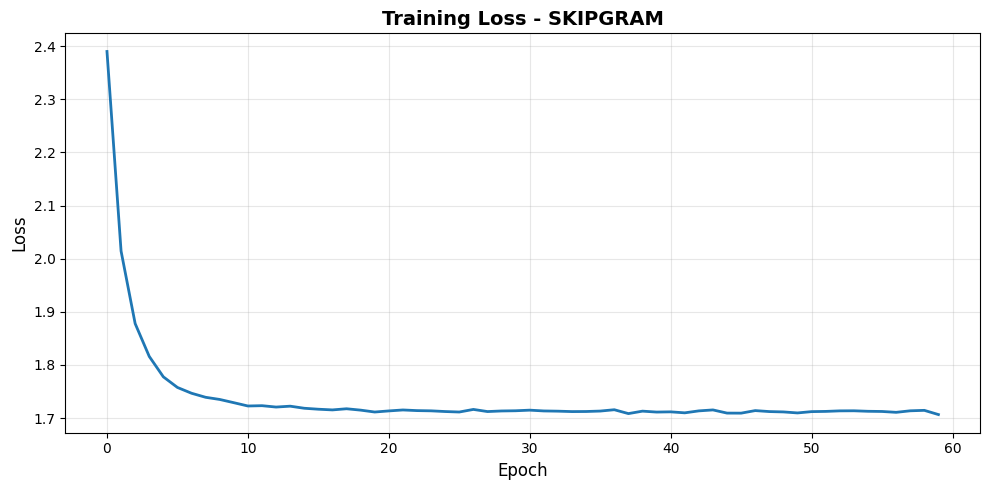

In [70]:
plt.figure(figsize=(10, 5))
plt.plot(losses, linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title(f'Training Loss - {MODE.upper()}', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [73]:
embeddings = model.get_embeddings()
print(f"Embeddings shape: {embeddings.shape}")
print(f"Each word is represented by a {EMBEDDING_DIM}-dimensional vector")

Embeddings shape: (2072, 100)
Each word is represented by a 100-dimensional vector


In [74]:
# Test word similarity
test_words = ['time', 'love', 'pain', 'wall', 'numb', 'money', 'sky']

for word in test_words:
    if word in vocab.word2idx:
        print(f"\nWords similar to '{word}':")
        similar = find_similar_words(word, embeddings, vocab, top_k=5)
        for similar_word, similarity in similar:
            print(f"  {similar_word}: {similarity:.4f}")
    else:
        print(f"\n'{word}' not in vocabulary")


Words similar to 'time':
  soothing: 0.3911
  ticks: 0.3657
  relieving: 0.3633
  whom: 0.3594
  someones: 0.3553

Words similar to 'love':
  heal: 0.3996
  lingers: 0.3850
  undying: 0.3841
  two: 0.3800
  madly: 0.3787

Words similar to 'pain':
  escape: 0.4054
  sin: 0.3935
  heavens: 0.3827
  castle: 0.3817
  king: 0.3815

Words similar to 'wall':
  rigby: 0.5465
  mire: 0.4912
  eleanor: 0.4820
  sunrise: 0.4793
  bein: 0.4482

Words similar to 'numb':
  comfortably: 0.5789
  supremacy: 0.4105
  clocks: 0.4035
  keepin: 0.3908
  swell: 0.3900

Words similar to 'money':
  green: 0.4295
  paid: 0.4070
  power: 0.4012
  painted: 0.3840
  team: 0.3827

Words similar to 'sky':
  diamonds: 0.5201
  forests: 0.4767
  dust: 0.4641
  lucy: 0.4539
  daughters: 0.4496


In [3]:
# Test word analogies
analogies = [
    ('dark', 'light', 'night'),
    ('love', 'hate', 'life'),
]

for word_a, word_b, word_c in analogies:
    print(f"\n{word_a} is to {word_b} as {word_c} is to:")
    result = word_analogy(word_a, word_b, word_c, embeddings, vocab, top_k=3)
    if isinstance(result, str):
        print(f"  {result}")
    else:
        for word, similarity in result:
            print(f"  {word}: {similarity:.4f}")


dark is to light as night is to:


NameError: name 'embeddings' is not defined

## Visualize Embeddings with t-SNE

Applying t-SNE...


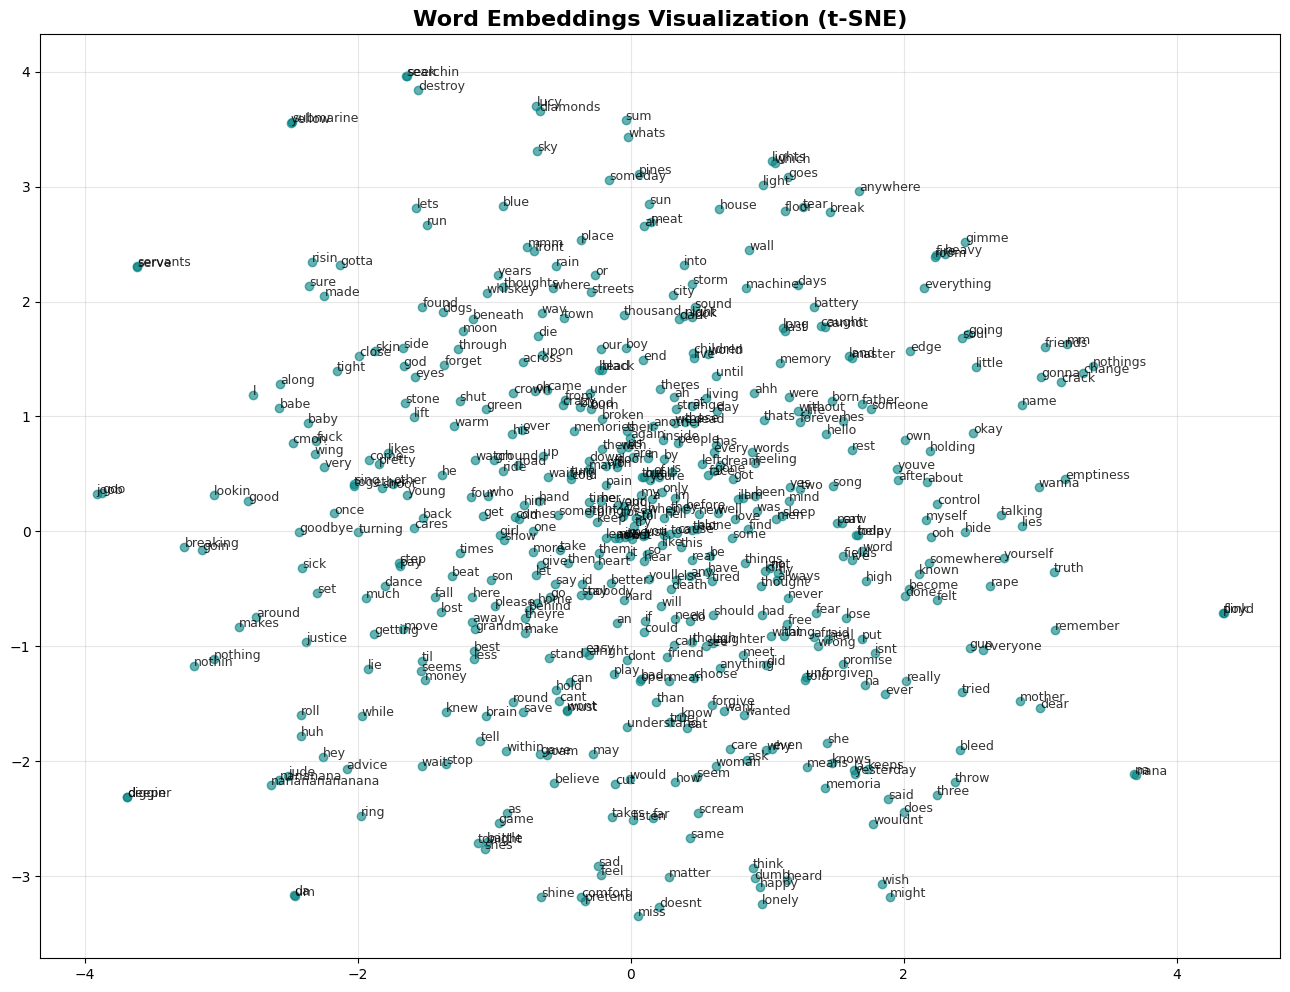

In [84]:
top_k = 200
common_words = [w for w, c in vocab.word_counts.most_common(top_k) if w in vocab.word2idx]
word_indices = [vocab.get_idx(w) for w in common_words]
word_vectors = embeddings[word_indices]

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(word_vectors)

plt.figure(figsize=(16, 12))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.6, c='teal')

for i, word in enumerate(common_words):
    plt.annotate(word, xy=(embeddings_2d[i, 0], embeddings_2d[i, 1]), 
                 fontsize=9, alpha=0.8)

plt.title('Word Embeddings Visualization (t-SNE)', fontsize=16, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.show()